<a href="https://colab.research.google.com/github/neethipoonacha/EIP3/blob/master/Gradcam_backup.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [25]:
# https://keras.io/
!pip install -q keras
import keras


!pip install Pillow
import scipy

In [0]:
# Load the Drive helper and mount
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive')

In [0]:
#lists the content of your google drive
!ls "/content/drive/My Drive"

In [0]:
#x=File.open('drive/My Drive/test/weight-01-0.33.hdf5')

with open('drive/My Drive/test/weight-01-0.33.hdf5', 'w') as f:
  f.write('Hello Google Drive!')
!cat drive/My\ Drive/test/weight-01-0.33.hdf5

Hello Google Drive!

In [0]:
import keras
from keras.datasets import cifar10
from keras.models import Model, Sequential
from keras.layers import Dense, Dropout, Flatten, Input, AveragePooling2D, merge, Activation
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from keras.layers import Concatenate
from keras.optimizers import SGD
from keras.callbacks import ReduceLROnPlateau
from keras.callbacks import LearningRateScheduler
from keras.preprocessing.image import ImageDataGenerator
from matplotlib import pyplot
#import numpy as np
#from scipy.misc import imread, imsave, imresize


In [0]:
# this part will prevent tensorflow to allocate all the avaliable GPU Memory
# backend
import tensorflow as tf
from keras import backend as k

# Don't pre-allocate memory; allocate as-needed
config = tf.ConfigProto()
config.gpu_options.allow_growth = True

# Create a session with the above options specified.
k.tensorflow_backend.set_session(tf.Session(config=config))

In [0]:
# Hyperparameters
batch_size = 64
num_classes = 10
epochs = 50
l = 40
num_filter = 12
compression = 0.5
dropout_rate = 0.2

In [32]:
# Load CIFAR10 Data
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
img_height, img_width, channel = x_train.shape[1],x_train.shape[2],x_train.shape[3]

# convert to one hot encoing 
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

print (x_train.shape)


(50000, 32, 32, 3)


In [0]:
def show_imgs(X):
    pyplot.figure(1)
    k = 0
    for i in range(0,4):
        for j in range(0,4):
            pyplot.subplot2grid((4,4),(i,j))
            pyplot.imshow(toimage(X[k]))
            k = k+1
    # show the plot
    pyplot.show()

In [0]:
#(x_train, y_train), (x_test, y_test) = cifar10.load_data()
show_imgs(x_test[:50])

In [0]:
from keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator( rotation_range=90, 
                 width_shift_range=0.1, height_shift_range=0.1, 
                 horizontal_flip=True) 
datagen.fit(x_train)

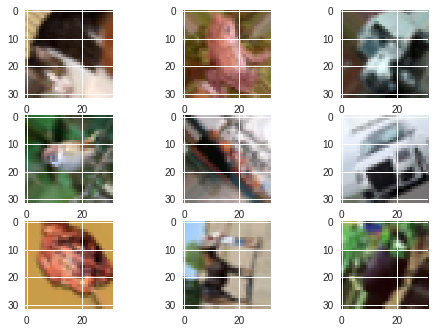

In [0]:
from matplotlib import pyplot as plt
# Configure batch size and retrieve one batch of images
for X_batch, y_batch in datagen.flow(x_train, y_train, batch_size=9):
    # Show 9 images
    for i in range(0, 9):
        pyplot.subplot(330 + 1 + i)
        pyplot.imshow(toimage(X_batch[i].reshape(x_train.shape[1], x_train.shape[2], 3)))
    # show the plot
    pyplot.show()
    break

In [0]:
# Dense Block
def add_denseblock(input, num_filter = 64, dropout_rate=0.0, weight_decay=1e-4):
    global compression
    temp = input
    for _ in range(l):
        BatchNorm = BatchNormalization()(temp)
        relu = Activation('relu')(BatchNorm)
        Conv2D_3_3 = Conv2D(int(num_filter*compression), (3,3), use_bias=False ,padding='same')(relu)
        if dropout_rate>0:
          Conv2D_3_3 = Dropout(dropout_rate)(Conv2D_3_3)
        concat = Concatenate(axis=-1)([temp,Conv2D_3_3])
        
        temp = concat
        
    return temp

In [0]:
def add_transition(input, num_filter = 32, dropout_rate = 0.1):
    global compression
    BatchNorm = BatchNormalization()(input)
    relu = Activation('relu')(BatchNorm)
    Conv2D_BottleNeck = Conv2D(int(num_filter*compression), (1,1), use_bias=False ,padding='same')(relu)
    if dropout_rate>0:
      Conv2D_BottleNeck = Dropout(dropout_rate)(Conv2D_BottleNeck)
    avg = AveragePooling2D(pool_size=(2,2))(Conv2D_BottleNeck)
    
    return avg

In [0]:
def output_layer(input):
    global compression
    BatchNorm = BatchNormalization()(input)
    relu = Activation('relu')(BatchNorm)
    AvgPooling = AveragePooling2D(pool_size=(2,2))(relu)
    flat = Flatten()(AvgPooling)
    output = Dense(num_classes, activation='softmax')(flat)
    
    return output

In [0]:
num_filter = 32
dropout_rate = 0.2
l = 15
input = Input(shape=(img_height, img_width, channel,))
First_Conv2D = Conv2D(num_filter, (3,3), use_bias=False ,padding='same')(input)

First_Block = add_denseblock(First_Conv2D, num_filter, dropout_rate)
First_Transition = add_transition(First_Block, num_filter, dropout_rate)

Second_Block = add_denseblock(First_Transition, num_filter, dropout_rate)
Second_Transition = add_transition(Second_Block, num_filter, dropout_rate)
dropout_rate = 0.1
Third_Block = add_denseblock(Second_Transition, num_filter, dropout_rate)
Third_Transition = add_transition(Third_Block, num_filter, dropout_rate)

#Last_Block = add_denseblock(Third_Transition,  num_filter, dropout_rate)

output = output_layer(Third_Transition)


In [0]:
model = Model(inputs=[input], outputs=[output])
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 32, 32, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 32, 32, 32)   128         conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 32, 32, 32)   0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
conv2d_2 (

In [0]:
# determine Loss function and Optimizer
model.compile(loss='categorical_crossentropy',
              optimizer=SGD(lr=0.1 ,decay=1e-4,momentum=0.9),
              metrics=['accuracy'])

In [0]:
def lr_schedule(epoch):
    lrate = 0.1
    if epoch > 32:
        lrate = 0.15
    elif epoch > 48:
        lrate = 0.2        
    return lrate

In [0]:
from keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator( rotation_range=90, 
                 width_shift_range=0.1, height_shift_range=0.1, 
                 horizontal_flip=True) 
datagen.fit(x_train)

In [0]:
#reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                       #       patience=5, min_lr=0.001)


#training
batch_size = 128

model.fit_generator(datagen.flow(x_train, y_train, batch_size=batch_size),\
                    steps_per_epoch=x_train.shape[0] // batch_size,epochs=30,\
                    verbose=1,validation_data=(x_test,y_test),callbacks=[LearningRateScheduler(lr_schedule)])

#model.save_weights('drive/My\ Drive/test/weight-01-0.33.hdf5')

Epoch 1/30
390/390 [==============================] - 321s 824ms/step - loss: 1.8202 - acc: 0.3353 - val_loss: 2.4529 - val_acc: 0.2688
Epoch 2/30
390/390 [==============================] - 300s 769ms/step - loss: 1.6394 - acc: 0.4027 - val_loss: 1.9500 - val_acc: 0.3669
Epoch 3/30
390/390 [==============================] - 300s 770ms/step - loss: 1.5003 - acc: 0.4551 - val_loss: 1.8553 - val_acc: 0.4286
Epoch 4/30
390/390 [==============================] - 300s 770ms/step - loss: 1.3820 - acc: 0.4963 - val_loss: 2.4107 - val_acc: 0.3491
Epoch 5/30
390/390 [==============================] - 300s 770ms/step - loss: 1.2969 - acc: 0.5336 - val_loss: 2.1739 - val_acc: 0.4000
Epoch 6/30
390/390 [==============================] - 300s 769ms/step - loss: 1.2280 - acc: 0.5585 - val_loss: 2.0932 - val_acc: 0.4455
Epoch 7/30
390/390 [==============================] - 300s 770ms/step - loss: 1.1696 - acc: 0.5817 - val_loss: 1.2144 - val_acc: 0.5877
Epoch 8/30
390/390 [============================

In [0]:
# Save the trained weights in to .h5 format
model.save_weights("DNST_model_one_save.h5")
print("Saved model to disk")

Saved model to disk


In [0]:
from google.colab import files

files.download('DNST_model_one_save.h5')

In [0]:
#imgAug = ImageDataGenerator(rotation_range=60,width_shift_range=0.1, zoom_range=0.1,horizontal_flip=True, height_shift_range=0.1)
#imgAug.fit(x_train)

#data augmentation
datagen = ImageDataGenerator(
    horizontal_flip=True
    )
datagen.fit(x_train)

In [0]:

#reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                          #    patience=5, min_lr=0.001)

model.load_weights("DNST_model_one_save.h5")

model.compile(loss='categorical_crossentropy',
              optimizer=SGD(lr=0.15 ,decay=1e-6,momentum=0.9),
              metrics=['accuracy'])

model.fit_generator(datagen.flow(x_train, y_train, batch_size=batch_size),\
                    steps_per_epoch= 2*x_train.shape[0] // batch_size,epochs=20,\
                    verbose=1,validation_data=(x_test,y_test))


model.save_weights("DNST_model_two_save.h5")


Epoch 1/20
781/781 [==============================] - 588s 753ms/step - loss: 0.5403 - acc: 0.8141 - val_loss: 0.9019 - val_acc: 0.7562
Epoch 2/20
781/781 [==============================] - 576s 738ms/step - loss: 0.4472 - acc: 0.8458 - val_loss: 0.8675 - val_acc: 0.7347
Epoch 3/20
781/781 [==============================] - 576s 738ms/step - loss: 0.3924 - acc: 0.8644 - val_loss: 0.6566 - val_acc: 0.8014
Epoch 4/20
781/781 [==============================] - 577s 739ms/step - loss: 0.3573 - acc: 0.8777 - val_loss: 0.4442 - val_acc: 0.8588
Epoch 5/20
781/781 [==============================] - 580s 743ms/step - loss: 0.3299 - acc: 0.8851 - val_loss: 0.6905 - val_acc: 0.8004
Epoch 6/20
781/781 [==============================] - 580s 743ms/step - loss: 0.3096 - acc: 0.8943 - val_loss: 0.5004 - val_acc: 0.8469
Epoch 7/20
781/781 [==============================] - 579s 742ms/step - loss: 0.2838 - acc: 0.9020 - val_loss: 0.4306 - val_acc: 0.8645
Epoch 8/20
781/781 [============================

In [0]:
# Test the model
score = model.evaluate(x_test, y_test, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

10000/10000 [==============================] - 26s 3ms/step
Test loss: 0.44008580334186553
Test accuracy: 0.8854


In [0]:
# Save the trained weights in to .h5 format
model.save_weights("DNST_model_two_save.h5")
print("Saved model to disk")

Saved model to disk


In [0]:
from google.colab import files

files.download('DNST_model_two_save.h5')

In [0]:
#data augmentation
datagen = ImageDataGenerator(    
    horizontal_flip=True
    )
datagen.fit(x_train)



In [0]:

model.load_weights("DNST_model_two_save.h5")

batch_size=64

model.compile(loss='categorical_crossentropy',
              optimizer=SGD(lr=0.01 ,decay=1e-10,momentum=0.9),
              metrics=['accuracy'])

model.fit_generator(datagen.flow(x_train, y_train, batch_size=batch_size),\
                    steps_per_epoch= x_train.shape[0] // batch_size,epochs=10,\
                    verbose=1,validation_data=(x_test,y_test))


model.save_weights("DNST_model_three_save.h5")

Epoch 1/10
781/781 [==============================] - 350s 448ms/step - loss: 0.1176 - acc: 0.9587 - val_loss: 0.3127 - val_acc: 0.9141
Epoch 2/10
781/781 [==============================] - 335s 429ms/step - loss: 0.1086 - acc: 0.9612 - val_loss: 0.3145 - val_acc: 0.9190
Epoch 3/10
781/781 [==============================] - 336s 430ms/step - loss: 0.0967 - acc: 0.9655 - val_loss: 0.3121 - val_acc: 0.9176
Epoch 4/10
781/781 [==============================] - 337s 431ms/step - loss: 0.0939 - acc: 0.9664 - val_loss: 0.3244 - val_acc: 0.9190
Epoch 5/10
781/781 [==============================] - 337s 432ms/step - loss: 0.0914 - acc: 0.9677 - val_loss: 0.3342 - val_acc: 0.9189
Epoch 6/10
781/781 [==============================] - 337s 432ms/step - loss: 0.0910 - acc: 0.9672 - val_loss: 0.3264 - val_acc: 0.9190
Epoch 7/10
781/781 [==============================] - 337s 431ms/step - loss: 0.0845 - acc: 0.9701 - val_loss: 0.3266 - val_acc: 0.9198
Epoch 8/10
781/781 [============================

In [0]:
# Test the model
score = model.evaluate(x_test, y_test, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

10000/10000 [==============================] - 26s 3ms/step
Test loss: 0.3500478660710156
Test accuracy: 0.9185


In [0]:
# Save the trained weights in to .h5 format
model.save_weights("DNST_model_three_save.h5")
print("Saved model to disk")

Saved model to disk


In [0]:
from google.colab import files

files.download('DNST_model_three_save.h5')

In [0]:
#datagen = ImageDataGenerator(
  #  horizontal_flip=True
  #  )
#datagen.fit(x_train)



model.load_weights("DNST_model_three_save.h5")

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=5, min_lr=0.001)
batch_size=64

#model.compile(loss='categorical_crossentropy',
            #  optimizer=SGD(lr=0.001 ,decay=1e-4,momentum=0.9),
            #  metrics=['accuracy'])

model.fit(x_train, y_train,
                    batch_size=64,
                    epochs=250,
                    verbose=1,
                    validation_data=(x_test, y_test),callbacks=[reduce_lr])

model.save_weights("DNST_model_four_save.h5")

Train on 50000 samples, validate on 10000 samples
Epoch 1/250
50000/50000 [==============================] - 346s 7ms/step - loss: 0.0758 - acc: 0.9726 - val_loss: 0.3350 - val_acc: 0.9206
Epoch 2/250
50000/50000 [==============================] - 336s 7ms/step - loss: 0.0735 - acc: 0.9739 - val_loss: 0.3293 - val_acc: 0.9212
Epoch 3/250
50000/50000 [==============================] - 336s 7ms/step - loss: 0.0722 - acc: 0.9738 - val_loss: 0.3332 - val_acc: 0.9208
Epoch 4/250
50000/50000 [==============================] - 336s 7ms/step - loss: 0.0719 - acc: 0.9747 - val_loss: 0.3340 - val_acc: 0.9206
Epoch 5/250
50000/50000 [==============================] - 336s 7ms/step - loss: 0.0729 - acc: 0.9742 - val_loss: 0.3331 - val_acc: 0.9212
Epoch 6/250
50000/50000 [==============================] - 336s 7ms/step - loss: 0.0725 - acc: 0.9740 - val_loss: 0.3334 - val_acc: 0.9204
Epoch 7/250
50000/50000 [==============================] - 336s 7ms/step - loss: 0.0740 - acc: 0.9730 - val_loss: 0.

KeyboardInterrupt: ignored

In [0]:
# Test the model
score = model.evaluate(x_test, y_test, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

10000/10000 [==============================] - 26s 3ms/step
Test loss: 0.3363751113705337
Test accuracy: 0.9209


In [0]:
# Save the trained weights in to .h5 format
model.save_weights("DNST_model_four_save.h5")
print("Saved model to disk")

Saved model to disk


In [0]:
from google.colab import files

files.download('DNST_model_four_save.h5')

In [0]:
# Test the model
score = model.evaluate(x_test, y_test, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

10000/10000 [==============================] - 26s 3ms/step
Test loss: 0.3363751113705337
Test accuracy: 0.9209


Weights are loaded and saved from disk ,Due to security issues was not able to  connect to google drive via office network

DNST_model_one_save.h5   https://drive.google.com/file/d/1ZqTvWcSFZV9xDFoSo2vZHX1Z0spPbSey/view?usp=sharing

DNST_model_two_save.h5 https://drive.google.com/file/d/1p0wLKjl-h6pU4-mQmwDPHGGGMhTtQOjJ/view?usp=sharing

DNST_model_three_save.h5 https://drive.google.com/file/d/1DIsnAVvePizUNZH-sQjPSQpifDjBT1DP/view?usp=sharing

DNST_model_four_save.h5 https://drive.google.com/file/d/1wIE1QARyX8A8HW0AvZNHtAkjwvHKOtoG/view?usp=sharing
